In [ ]:
"""
This notebook demonstrates how to compute spectrum of a random matrix 
\Lambda_P=PU^{\dag}PUP when random unitary U is constructed using 
finite-depth two-dimensional quantum circuits.
These circuits consist of local 2-qubit fSim or random Clifford gates in the 
brickwall pattern (first over x, then over y direction) 
as well as (possibly) various single-qubit gates.
P is a projector (with a specified rank).
Random Clifford gates are generated using Qiskit.
No Qiskit is needed if Clifford gates are not used.

Packages information:
---------------------
numpy version = 1.26.4
scipy version = 1.13.1
qiskit version = 1.2.0
"""

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import matplotlib.pyplot as plt
import random
from qiskit.quantum_info import random_clifford

### Some helpful fuctions:

In [2]:
def int2bits(L, n):
    """
    Converts integer n to a bit string of length L
    (with zeros added to the front of the binary string, if needed).
    """
    return format(n,'0{}b'.format(L))


def Flip(L, n, i):
    """
    Flips a bit with an index i in a binary representation (of length L) of an
    integer n.

    Parameters
    ----------
    L : int
        Length of a binary representation of integer n (with zeros added to the
        front of the binary string, if needed).
    n : int
        Integer, whose binary representation is subjected to bit flipping.
    i : int
        Index of a bit being flipped.

    Returns
    -------
    n_bitflipped : int
        Integer represeting the binary with the flipped bit.
    """
    n_bitflipped = n^(1<<(L-(i+1)))
    return n_bitflipped


def embedded_1q_gate(L, U, q):
    """
    Constructs a sparse CSR matrix corresponding to a single-qubit gate U acting on
    a qubit with position q in a one-dimensional chain of L qubits.
    Standard computational basis is assumed.
    The dimensionality of the resulting matrix is 2**L.
    
    Parameters
    ----------
    L : int
        Length of a qubit chain.
    U : np.ndarray
        2x2 matrix representing a single-qubit gate.
    q : int
        Position of the qubit acted on by U within the qubit chain.
    """
    index=[[0,1],[1,0]]
    data=[]
    row = []
    col = []
    for n in range(2**L):
        for j in range(2):
            if int(int2bits(L, n)[q]) == j:
                [col.append(n) for k in range(2)]
                row.append(n)
                row.append(Flip(L, n, q))
                [data.append(U[index[j][k],j]) for k in range(2)]
    return csr_matrix((data, (row, col)), shape=(2**L, 2**L), dtype=np.complex128)


def array_gates(L, U):
    """
    Constructs a list of sparse CSR matrices corresponding to single-qubit gates U
    acting on each qubit within the qubit chain of length L.
    Dimensionality of each matrix is 2**L.
    """
    gates = []
    for q in range(L):
        gates.append( embedded_1q_gate(L=L,U=U,q=q) )
    return gates


def embedded_2q_gate(L, U, q1, q2):
    """
    Constructs a sparse CSR matrix corresponding to a two-qubit gate U acting on
    qubits with positions q1 and q2 in a one-dimensional chain of L qubits.
    Standard computational basis is assumed.
    The dimensionality of the resulting matrix is 2**L.
    
    Parameters
    ----------
    L : int
        Length of a qubit chain.
    U : np.ndarray
        2x2 matrix representing a single-qubit gate.
    q1 : int
        Position of the first qubit acted on by U within the qubit chain.
    q2 : int
        Position of the second qubit acted on by U within the qubit chain.
    """
    index=[[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]]
    data=[]
    row = []
    col = []
    for n in range(2**L):
        for j in range(4):
            if (int(int2bits(L, n)[q1]) == int(int2bits(2,j)[0]) and 
                int(int2bits(L, n)[q2])==int(int2bits(2,j)[1]) ):
                [col.append(n) for k in range(4)]
                row.append(n)
                row.append(Flip(L, n, q2))
                row.append(Flip(L, n, q1))
                row.append(Flip(L, Flip(L, n, q2), q1))
                [data.append(U[index[j][k],j]) for k in range(4)]
    return csr_matrix((data, (row, col)), shape=(2**L, 2**L), dtype=np.complex128)


def fSim_2q_gate(theta, phi, beta):
    """
    Constructs a two-qubit fSim gate (with parameters theta, phi and beta)
    as a 4x4 matrix.
    
    Parameters
    ----------
    theta : float
    phi : float
    beta : float
    """
    return np.array(
        [[1,0,0,0],
         [0,np.cos(theta),1j*np.exp(1j*beta)*np.sin(theta),0],
         [0,1j*np.exp(-1j*beta)*np.sin(theta),np.cos(theta),0],
         [0,0,0,np.exp(1j*phi)]]
    )

### Generate 1-qubit Pauli matrices and their combinations:

In [3]:
X_1q = np.array([[0,1],[1,0]])
Y_1q = np.array([[0,-1j],[1j,0]])
Z_1q = np.array([[1,0],[0,-1]])
W_1q = (X_1q+Y_1q)/np.sqrt(2)
V_1q = (X_1q-Y_1q)/np.sqrt(2)

### Main class:

In [4]:
class simulation_2D:
    """
    Class to compute the spectrum of \Lambda_P=PU^{\dag}PUP, when U is constructed
    as a local 2D quantum circuit.
    These circuits consist of local 2-qubit fSim or random Clifford gates in the 
    brickwall pattern (first over x, then over y direction) 
    as well as (possibly) various single-qubit gates.
    For numercial encoding, 2D grid is transformed into a 1D circuit with nonlocal
    interactions.
    P is a projector (with a specified rank).
    
    Attributes
    ----------
    Lx : int
        Number of qubits in x-direction of the 2D qubit grid.
    Ly : int
        Number of qubits in y-direction of the 2D qubit grid.
    b : float
        Projection dimension. rank[P]=b*n. Requirement that b*2**L is integer.
    theta : float
        Parameter of the fSim gate (if U is constructed using fSim gates).
    phi : float
        Parameter of the fSim gate (if U is constructed using fSim gates).
    beta : float
        Parameter of the fSim gate (if U is constructed using fSim gates).
    """
    def __init__(self, Lx, Ly, b, theta=None, phi=None, beta=None):
        self.Lx = Lx
        self.Ly = Ly
        self.L = Lx*Ly
        self.b = b
        if theta != None:
            self.theta = theta
        if phi != None:
            self.phi = phi
        if beta != None:
            self.beta = beta

        # constructing square roots of single-qubit gates
        self.sqrtX = array_gates(self.L, sp.linalg.sqrtm(X_1q))
        self.sqrtY = array_gates(self.L, sp.linalg.sqrtm(Y_1q))
        self.sqrtW = array_gates(self.L, sp.linalg.sqrtm(W_1q))
        self.sqrtV = array_gates(self.L, sp.linalg.sqrtm(V_1q))

        # constructing lists of single-qubit Pauli gates
        self.X = array_gates(self.L, X_1q)
        self.Y = array_gates(self.L, Y_1q)
        self.Z = array_gates(self.L, Z_1q)

        # constructing a dictionary of local (nearest-neighbor) fSim gates
        # fSim[0] corresponds to the horizontal (x-direction) bonds
        # fSim[1] corresponds to the vertical (y-direction) bonds
        # periodic BC are assumed
        self.fSim = dict()
        self.fSim[0] = []
        self.fSim[1] = []
        for j in range(self.Ly):
            for i in range(self.Lx):
                self.fSim[0].append(embedded_2q_gate(L=self.L,
                                                     U=fSim_2q_gate(theta=self.theta,
                                                                    phi=self.phi,
                                                                    beta=self.beta),
                                                     q1=self.Lx*j+i,
                                                     q2=self.Lx*j+(i+1)%self.Lx
                                                    )
                                   )              
        for j in range(self.Ly):
            for i in range(self.Lx):
                self.fSim[1].append(embedded_2q_gate(L=self.L,
                                                     U=fSim_2q_gate(theta=self.theta,
                                                                    phi=self.phi,
                                                                    beta=self.beta
                                                                   ),
                                                     q1=self.Lx*j+i,
                                                     q2=self.Lx*((j+1)%self.Ly) + i
                                                    )
                                   )

        # constructing projector P
        # it is assumed that P is acting on the first k qubits
        # k depends on the projection dimension b
        # for example, for b=1/2, k=1, while for b=1/4 (or b=3/4), k=2, etc.
        data = [1 for i in range(int(self.b*2**self.L))]
        row = [i for i in range(int(self.b*2**self.L))]
        self.P = csr_matrix((data, (row, row)), shape=(2**self.L, 2**self.L), dtype=np.int8)


    def generate_random_1q(self, q, qc_type):
        """
        Generates a sparse CSR matrix of dim=2**L corresponding to a random single-qubit
        gate acting on qubit with position q within the 1D chain of L qubits.
        (Here 2D grid is transformed into a 1D chain layer by layer).

        Parameters
        ----------
        q : int
        qc_type : str
            Type of a random single-qubit gate.
            Possible options: 'sqrt' -- square root of Paulis X, Y or their combinations W, V
                              'XYZ' -- Paulis 1, X, Y, or Z
                              'RZ' -- Pauli-Z rotation with a random angle
        """
        if qc_type == 'sqrt':
            rnd = random.choice([0, 1, 2, 3])
            if rnd == 0:
                random_1q = self.sqrtX[q]
            if rnd == 1:
                random_1q = self.sqrtY[q]
            if rnd == 2:
                random_1q = self.sqrtW[q]
            if rnd == 3:
                random_1q = self.sqrtV[q]

        if qc_type == 'XYZ':
            rnd = random.choice([0, 1, 2, 3])
            if rnd == 0:
                random_1q = identity(2**self.L, dtype='int8')
            if rnd == 1:
                random_1q = self.X[q]
            if rnd == 2:
                random_1q = self.Y[q]
            if rnd == 3:
                random_1q = self.Z[q]
        
        if qc_type == 'RZ':
            angle_rnd = random.uniform(0, 2*np.pi)   
            random_1q = embedded_1q_gate(
                                    L=L,
                                    U=sp.sparse.linalg.expm(-1j*angle_rnd/2*Z_1q),
                                    q=q
                                    )  
        return random_1q

    
    def generate_Lambda_P_2D(self, depth, qc_type, BC='open'):
        """
        Generates matrix \Lambda_P=PU^{\dag}PUP.
        
        Parameters
        ----------
        depth : int
            Depth (number of layers) of a 2D quantum circuit generating U.
        qc_type : str
            Type of two-qubit and single-qubit gates.
            Possible options: 'clifford' -- random Clifford two-qubit gates, no single-qubit gates
                              'no1q' -- fSim two-qubit gates, no single-qubit gates
                              'sqrt' -- fSim two-qubit gates, 
                                        square root of Paulis X, Y or their combinations W, V for single-qubit gates
                              'XYZ' -- fSim two-qubit gates,
                                       Paulis 1, X, Y, or Z for single-qubit gates
                              'RZ' -- fSim two-qubit gates,
                                      Pauli-Z rotations with a random angle for single-qubit gates
        BC : str
            Boundary conditions for the 2D qubit grid.
            Possible options: 'periodic', 'open'.

        Returns
        -------
        Lambda_P : scipy.csr_matrix
            Matrix Lambda_P.
        """        
        A = self.P
        for layer in range(depth):
            if BC=='open':
                if qc_type == 'clifford':
                    if self.Lx%2 == 0:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx):
                                if ix % 2 == 0:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+ix+1) @ A   
                    if self.Lx%2 == 1:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx-1):
                                if ix % 2 == 0:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+ix+1) @ A  

                    if self.Lx%2 == 0:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx-1):
                                if ix % 2 == 1:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+ix+1) @ A
                    if self.Lx%2 == 1:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx):
                                if ix % 2 == 1:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+ix+1) @ A

                    if self.Ly%2 == 0:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly):
                                if iy % 2 == 0:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*(iy+1) + ix) @ A 
                    if self.Ly%2 == 1:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly-1):
                                if iy % 2 == 0:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*(iy+1) + ix) @ A 

                    if self.Ly%2 == 0:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly-1):
                                if iy % 2 == 1:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*(iy+1) + ix) @ A  
                    if self.Ly%2 == 1:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly):
                                if iy % 2 == 1:
                                    rng = np.random.default_rng()
                                    U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                    A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*(iy+1) + ix) @ A 
                else:
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    if self.Lx%2 == 0:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx):
                                if ix % 2 == 0:
                                    A = self.fSim[0][ix+self.Lx*iy] @ A   
                    if self.Lx%2 == 1:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx-1):
                                if ix % 2 == 0:
                                    A = self.fSim[0][ix+self.Lx*iy] @ A  
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    if self.Lx%2 == 0:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx-1):
                                if ix % 2 == 1:
                                    A = self.fSim[0][ix+self.Lx*iy] @ A   
                    if self.Lx%2 == 1:
                        for iy in range(self.Ly):
                            for ix in range(self.Lx):
                                if ix % 2 == 1:
                                    A = self.fSim[0][ix+self.Lx*iy] @ A  
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    if self.Ly%2 == 0:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly):
                                if iy % 2 == 0:
                                    A = self.fSim[1][ix+self.Lx*iy] @ A 
                    if self.Ly%2 == 1:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly-1):
                                if iy % 2 == 0:
                                    A = self.fSim[1][ix+self.Lx*iy] @ A 
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    if self.Ly%2 == 0:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly-1):
                                if iy % 2 == 1:
                                    A = self.fSim[1][ix+self.Lx*iy] @ A 
                    if self.Ly%2 == 1:
                        for ix in range(self.Lx):
                            for iy in range(self.Ly):
                                if iy % 2 == 1:
                                    A = self.fSim[1][ix+self.Lx*iy] @ A            
            if BC=='periodic':
                if qc_type == 'clifford':
                    for iy in range(self.Ly):
                        for ix in range(self.Lx):
                            if ix % 2 == 0:
                                rng = np.random.default_rng()
                                U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+(ix+1)%self.Lx) @ A
                    for iy in range(self.Ly):
                        for ix in range(self.Lx):
                            if ix % 2 == 1:
                                rng = np.random.default_rng()
                                U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*iy+(ix+1)%self.Lx) @ A                                
                    for ix in range(self.Lx):
                        for iy in range(self.Ly):
                            if iy % 2 == 0:
                                rng = np.random.default_rng()
                                U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*((iy+1)%self.Ly) + ix) @ A 
                    for ix in range(self.Lx):
                        for iy in range(self.Ly):
                            if iy % 2 == 1:
                                rng = np.random.default_rng()
                                U = random_clifford(num_qubits=2,seed=rng).to_operator().data
                                A = embedded_2q_gate(L=self.L,U=U,q1=self.Lx*iy+ix,q2=self.Lx*((iy+1)%self.Ly) + ix) @ A 
                else:
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    for iy in range(self.Ly):
                        for ix in range(self.Lx):
                            if ix % 2 == 0:
                                A = self.fSim[0][ix+self.Lx*iy] @ A 
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    for iy in range(self.Ly):
                        for ix in range(self.Lx):
                            if ix % 2 == 1:
                                A = self.fSim[0][ix+self.Lx*iy] @ A  
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    for ix in range(self.Lx):
                        for iy in range(self.Ly):
                            if iy % 2 == 0:
                                A = self.fSim[1][ix+self.Lx*iy] @ A   
                    if qc_type != 'no1q':
                        for i in range(self.L): 
                            A = self.generate_random_1q(i,qc_type) @ A
                    for ix in range(self.Lx):
                        for iy in range(self.Ly):
                            if iy % 2 == 1:
                                A = self.fSim[1][ix+self.Lx*iy] @ A
        Lambda_P = csr_matrix.transpose(csr_matrix.conjugate(A)) @ self.P @ A
        
        return Lambda_P

    
    def calculate_spectrum(self,depth,qc_type,BC,runs):
        """
        Generates matrix Lambda_P and calculates its eigenvalues.

        Parameters
        ----------
        runs : int
            Number of random-matrix realizations over which the averaging is performed.
        """
        eigenvals = []
        for i in range(runs):
            W = self.generate_Lambda_P_2D(depth=depth,qc_type=qc_type,BC=BC)
            eigenvals.append( np.linalg.eigvals(W.toarray()) )
        self.eigenvals = np.ndarray.flatten(np.real(eigenvals))
        

## Results:

In [5]:
%%time

Lx = 3
Ly = 3
b = 1/4
depth = 10
qc_type = 'sqrt'
BC = 'open'
runs = 20
theta = np.pi/6
phi = 2*np.pi/3
# theta = np.pi/4
# phi = 0.0

Lambda_P = simulation_2D(
                Lx=Lx,
                Ly=Ly,
                b=b,
                theta=theta,
                phi=phi,
                beta=0.0
            )

Lambda_P.calculate_spectrum(
    depth=depth, 
    qc_type=qc_type, 
    BC=BC, 
    runs=runs
)
    
eigenvals_2D = Lambda_P.eigenvals

CPU times: user 4.64 s, sys: 216 ms, total: 4.85 s
Wall time: 4.84 s


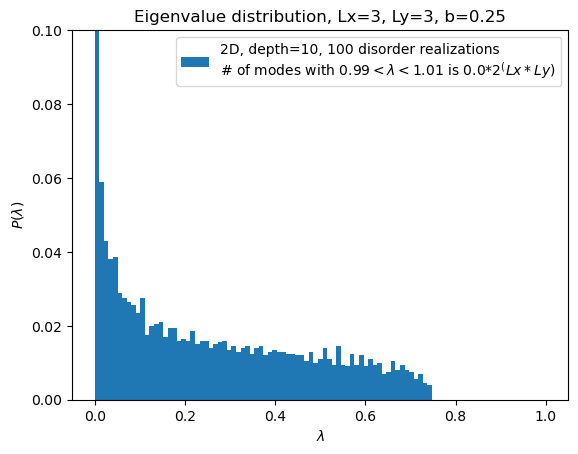

In [6]:
modes_one = round(len([i for i in eigenvals_2D if 0.99<i<1.01])/2**(Lx*Ly),2)/2000
plt.hist(eigenvals_2D,
         bins=np.linspace(0,1,100),
         weights=np.ones_like(eigenvals_2D)/2000,
         label='2D, depth=%s, 100 disorder realizations\n# of modes with $0.99<\lambda<1.01$ is %s*$2^(Lx*Ly)$' % (depth, modes_one)
        )
plt.ylim(0,0.1)
plt.title('Eigenvalue distribution, Lx=%s, Ly=%s, b=%s' % (Lx,Ly,b))
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$P(\lambda)$')
# plt.savefig('depth=%s, b=%s.png' % (depth, b))
plt.show()


In [7]:
%%time

Lx = 3
Ly = 3
b = 1/4
depth = 2
qc_type = 'sqrt'
BC = 'open'
runs = 20
theta = np.pi/6
phi = 2*np.pi/3
# theta = np.pi/4
# phi = 0.0

Lambda_P = simulation_2D(
                Lx=Lx,
                Ly=Ly,
                b=b,
                theta=theta,
                phi=phi,
                beta=0.0
            )

Lambda_P.calculate_spectrum(
    depth=depth, 
    qc_type=qc_type, 
    BC=BC, 
    runs=runs
)
    
eigenvals_2D = Lambda_P.eigenvals

CPU times: user 1.31 s, sys: 187 ms, total: 1.49 s
Wall time: 1.4 s


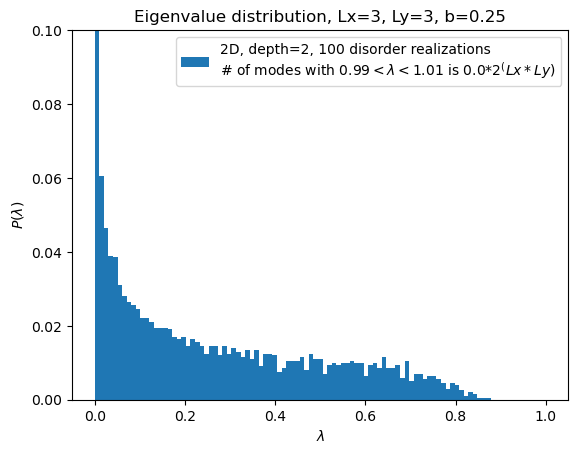

In [8]:
modes_one = round(len([i for i in eigenvals_2D if 0.99<i<1.01])/2**(Lx*Ly),2)/2000
plt.hist(eigenvals_2D,
         bins=np.linspace(0,1,100),
         weights=np.ones_like(eigenvals_2D)/2000,
         label='2D, depth=%s, 100 disorder realizations\n# of modes with $0.99<\lambda<1.01$ is %s*$2^(Lx*Ly)$' % (depth, modes_one)
        )
plt.ylim(0,0.1)
plt.title('Eigenvalue distribution, Lx=%s, Ly=%s, b=%s' % (Lx,Ly,b))
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$P(\lambda)$')
# plt.savefig('depth=%s, b=%s.png' % (depth, b))
plt.show()
